In [2]:
import os
import glob
import numpy as np
import math
import random
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd
import warnings 
warnings.filterwarnings('ignore')

import wandb

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets
from torchvision import models
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn.metrics import f1_score



In [4]:
def seed_everything(seed: int = 16):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore
    
seed_everything(16)

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print(device)
    

cuda Tesla V100-PCIE-32GB


In [6]:
## 초기 설정 -> 연예인 리스트, batch size, epochs, lr, ...
exp_name = 'small_efficientnet_b7'

train_csv = 'train.csv'
valid_csv = 'valid.csv'
celeb_list = [
    '공유', '권나라', '문채원', '박하선', '배두나', '신민아', '신성록', '안재현', '여진구', '유아인',
    '이다희', '이병헌', '이선균', '이시영', '전미도', '정은지', '조정석', '차승원', '한선화', '현빈',
]

val_saved = 5

batch_size = 16   # Mini-batch size
num_epochs = 20
learning_rate = 0.0001

In [7]:
dataset_path = './data/'
train_csv_path = os.path.join(dataset_path, train_csv)
valid_csv_path = os.path.join(dataset_path, valid_csv)
saved_path = os.path.join(dataset_path, 'saved', exp_name)
os.makedirs(saved_path, exist_ok=True)

train_df = pd.read_csv(train_csv_path)
valid_df = pd.read_csv(valid_csv_path)

train_df.head()


,Unnamed: 0,path,name
0,0,images/신민아/신민아_001.jpg,신민아
1,1,images/신민아/신민아_003.jpg,신민아
2,2,images/신민아/신민아_009.jpg,신민아
3,3,images/신민아/신민아_010.jpg,신민아
4,4,images/신민아/신민아_012.jpg,신민아


In [8]:
train_df.head()

,Unnamed: 0,path,name
0,0,images/신민아/신민아_001.jpg,신민아
1,1,images/신민아/신민아_003.jpg,신민아
2,2,images/신민아/신민아_009.jpg,신민아
3,3,images/신민아/신민아_010.jpg,신민아
4,4,images/신민아/신민아_012.jpg,신민아


In [9]:
valid_df.head()

,Unnamed: 0,path,name
0,0,images/신민아/신민아_000.jpg,신민아
1,1,images/신민아/신민아_002.jpg,신민아
2,2,images/신민아/신민아_007.jpg,신민아
3,3,images/신민아/신민아_008.jpg,신민아
4,4,images/신민아/신민아_011.jpg,신민아


In [10]:
class CustomDataset(Dataset):
    def __init__(self, df, mode='train', transform=None):
        self.df = df
        self.mode = mode
        self.transform = transform

    def __getitem__(self, idx):

        img_path = os.path.join(dataset_path, self.df['path'][idx])

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img /= 255.0
        
        if self.transform is not None:
            transformed = self.transform(image=img)
            img = transformed['image']

        if self.mode in ('train', 'val'):
            label = self.df['name'][idx]
            label = celeb_list.index(label)
            
            return img, label

        elif self.mode == 'test':
            return img
    
    def __len__(self):
        return len(self.df)

In [11]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([
                            A.Resize(256,256),
                            ToTensorV2()
                            ])

val_transform = A.Compose([
                          A.Resize(256,256),
                          ToTensorV2()
                          ])

# test_transform = A.Compose([
#                            ToTensorV2()
#                            ])

In [12]:
# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

## dataset 구성
train_dataset = CustomDataset(train_df, mode="train", transform=train_transform)

# 나중에 train_df -> val_df
val_dataset = CustomDataset(valid_df, mode="val", transform=val_transform)

# test_dataset = CustomDataset(test_df, mode="test", transform=test_transform)

## dataloader 구성
train_loader = DataLoader(
            train_dataset, 
            batch_size=batch_size, 
            shuffle=True, 
            num_workers=4
        )
val_loader = DataLoader(
            val_dataset, 
            batch_size=batch_size, 
            shuffle=True, 
            num_workers=4
        )

여진구
torch.Size([3, 256, 256])


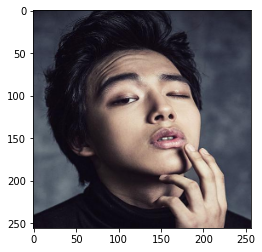

In [34]:
## 잘 나오는 지 중간 테스트 (필요에 따라 사용하시면 욀 것 같습니다.)
for img, label in train_loader:
    temp_img = img
    temp_label = label
    print(celeb_list[temp_label[0]])
    break
print(temp_img[0].shape)
plt.imshow(temp_img[0].permute([1,2,0]))    

# print(celeb_list[temp_label[0]])
# plt.imshow(temp_img[0].permute([1,2,0]))


In [14]:
## model 정의 (원하는 모델로 바꾸면 될 것 같습니다!)
model = torchvision.models.efficientnet_b7(pretrained = True)
model

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivatio

In [15]:
model.classifier[1] = nn.Linear(in_features=2560, out_features=len(celeb_list), bias=True)


In [35]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, betas = (0.5, 0.999))

In [22]:
wandb.init(project='final-project', entity='cv-3-bitcoin', name=exp_name, config={"epochs": num_epochs, "batch_size": batch_size, "lr":learning_rate})


accuracy,▁
f1 score,▁
train loss,██▆▆▂▁▁
val loss,▁████
accuracy,0.62189
f1 score,0.60476
train loss,0.82587
val loss,1.31955


In [23]:
## train & validation
best_f1 = 1e10
for epoch in tqdm(range(num_epochs)):
    print("\nEpoch ", epoch+1)
    
    ## train
    print("\nTrain:")
    model.train()
    train_loss = 0
    for i, (img, label) in enumerate(train_loader): 
        img, label = img.to(device), label.to(device)
        pred = model(img)
        loss = criterion(pred, label)    
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if ((i+1) % (len(train_loader) // 3) == 1) or i+1 == len(train_loader):
            display_loss = '[%3d/%3d] | Loss: %.5f'%(i+1, len(train_loader), train_loss/(i+1))
            print(display_loss)
        
            wandb.log({'train loss': train_loss/(i+1)})
            
    ## validation
    print("\nValidation:")
    with torch.no_grad():
        model.eval()
        val_loss = 0
        total = 0
        correct = 0
        label_list = []
        pred_list = []
        
        for i, (img, label) in enumerate(val_loader):
            img, label = img.to(device), label.to(device)
            pred = model(img)
            loss = criterion(pred, label)    
            val_loss += loss.item()

            _, predicted = pred.max(1)
            total += label.size(0)
            correct += predicted.eq(label).sum().item()
            label_list.append(label)
            pred_list.append(predicted)

            if ((i+1) % (len(val_loader) // 3) == 1) or i+1 == len(val_loader):
                display_loss = '[%3d/%3d] | Loss: %.5f'%(i+1, len(val_loader), val_loss/(i+1))
                print(display_loss)
                wandb.log({'val loss': val_loss/(i+1)})

        f1 = f1_score(torch.cat(label_list).to('cpu'), torch.cat(pred_list).to('cpu'), average = 'macro')
        print(f"Acc: {100.*correct / total:.2f}%")
        print(f"F1_score: {f1:.2f}")
        wandb.log({"f1 score": f1, 'accuracy': correct / total})
        
        

    if (epoch % val_saved) == val_saved-1:
        print(f"Epoch {epoch+1} is saved!")
        torch.save(model.state_dict(), os.path.join(saved_path, f'epoch_{epoch+1}.pt'))
    
    if best_f1 < f1:
        print(f"f1 is minimum! | will be saved!")
        torch.save(model.state_dict(), os.path.join(saved_path, f'best_f1.pt'))
        best_f1 = f1
wandb.finish()

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch  1

Train:
[  1/154] | Loss: 0.58945
[ 52/154] | Loss: 0.30027
[103/154] | Loss: 0.29478
[154/154] | Loss: 0.27916

Validation:
[  1/ 38] | Loss: 0.42556
[ 13/ 38] | Loss: 0.32529
[ 25/ 38] | Loss: 0.37359
[ 37/ 38] | Loss: 0.43271
[ 38/ 38] | Loss: 0.43558
Acc: 86.73%
F1_score: 0.87
f1 is minimum! | will be saved!


  5%|▌         | 1/20 [00:58<18:23, 58.08s/it]


Epoch  2

Train:
[  1/154] | Loss: 0.04742
[ 52/154] | Loss: 0.12887
[103/154] | Loss: 0.13505
[154/154] | Loss: 0.11970

Validation:
[  1/ 38] | Loss: 1.31061
[ 13/ 38] | Loss: 0.42913
[ 25/ 38] | Loss: 0.40695


 10%|█         | 2/20 [01:54<17:08, 57.11s/it]

[ 37/ 38] | Loss: 0.42534
[ 38/ 38] | Loss: 0.42213
Acc: 88.39%
F1_score: 0.88

Epoch  3

Train:
[  1/154] | Loss: 0.06128
[ 52/154] | Loss: 0.07294
[103/154] | Loss: 0.06844
[154/154] | Loss: 0.07062

Validation:
[  1/ 38] | Loss: 0.15648
[ 13/ 38] | Loss: 0.46339
[ 25/ 38] | Loss: 0.40429


 15%|█▌        | 3/20 [02:51<16:08, 56.95s/it]

[ 37/ 38] | Loss: 0.37697
[ 38/ 38] | Loss: 0.36923
Acc: 88.39%
F1_score: 0.88

Epoch  4

Train:
[  1/154] | Loss: 0.01036
[ 52/154] | Loss: 0.06378
[103/154] | Loss: 0.05608
[154/154] | Loss: 0.05672

Validation:
[  1/ 38] | Loss: 0.08214
[ 13/ 38] | Loss: 0.33957
[ 25/ 38] | Loss: 0.33160


 20%|██        | 4/20 [03:47<15:06, 56.68s/it]

[ 37/ 38] | Loss: 0.30523
[ 38/ 38] | Loss: 0.29755
Acc: 92.21%
F1_score: 0.92

Epoch  5

Train:
[  1/154] | Loss: 0.04879
[ 52/154] | Loss: 0.05403
[103/154] | Loss: 0.05266
[154/154] | Loss: 0.05191

Validation:
[  1/ 38] | Loss: 0.24122
[ 13/ 38] | Loss: 0.36054
[ 25/ 38] | Loss: 0.35432
[ 37/ 38] | Loss: 0.32802
[ 38/ 38] | Loss: 0.32517
Acc: 90.38%
F1_score: 0.90
Epoch 5 is saved!


 25%|██▌       | 5/20 [04:44<14:13, 56.87s/it]


Epoch  6

Train:
[  1/154] | Loss: 0.09446
[ 52/154] | Loss: 0.05318
[103/154] | Loss: 0.05437
[154/154] | Loss: 0.05451

Validation:
[  1/ 38] | Loss: 0.50156
[ 13/ 38] | Loss: 0.44088
[ 25/ 38] | Loss: 0.37355


 30%|███       | 6/20 [05:41<13:14, 56.77s/it]

[ 37/ 38] | Loss: 0.41937
[ 38/ 38] | Loss: 0.41888
Acc: 87.06%
F1_score: 0.87

Epoch  7

Train:
[  1/154] | Loss: 0.03334
[ 52/154] | Loss: 0.04547
[103/154] | Loss: 0.04234
[154/154] | Loss: 0.03981

Validation:
[  1/ 38] | Loss: 0.47024
[ 13/ 38] | Loss: 0.25159
[ 25/ 38] | Loss: 0.27077


 35%|███▌      | 7/20 [06:37<12:16, 56.63s/it]

[ 37/ 38] | Loss: 0.28457
[ 38/ 38] | Loss: 0.27729
Acc: 91.54%
F1_score: 0.91

Epoch  8

Train:
[  1/154] | Loss: 0.01010
[ 52/154] | Loss: 0.02355
[103/154] | Loss: 0.02122
[154/154] | Loss: 0.01998

Validation:
[  1/ 38] | Loss: 0.31406
[ 13/ 38] | Loss: 0.42232
[ 25/ 38] | Loss: 0.33755


 40%|████      | 8/20 [07:33<11:17, 56.48s/it]

[ 37/ 38] | Loss: 0.32933
[ 38/ 38] | Loss: 0.32266
Acc: 90.71%
F1_score: 0.91

Epoch  9

Train:
[  1/154] | Loss: 0.00384
[ 52/154] | Loss: 0.01083
[103/154] | Loss: 0.01437


In [41]:
## grad CAM
def CAM(fm, w, pred, shape):
    """
    feature_map: [1280, 16, 12]
    classfier weight: [18, 1280]
    image: [3, 512, 384]
    """
    img_shape = shape[1], shape[2]
    cm = w[pred]**2 @ fm.view(fm.shape[0], -1) # [16 * 12]
    cm = cm.view(fm.shape[1], fm.shape[2]) # [16, 12]
    cm = cm - torch.min(cm)
    cm = cm / torch.max(cm) # 0 ~ 1
    cm = torchvision.transforms.ToPILImage()(cm)
    cm = torchvision.transforms.Resize(img_shape)(cm)
    return cm

cam_transform = A.Compose([
                        ToTensorV2()
                        ])

(-0.5, 392.5, 467.5, -0.5)

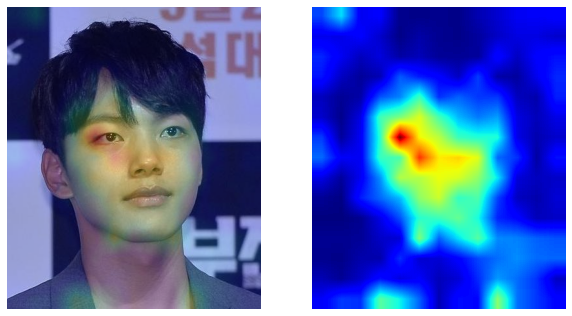

In [71]:
img_path = './data/images/공유/공유_003.jpg'

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
img /= 255.0

transformed = cam_transform(image=img)
img = transformed['image']
shape = img.shape

model = model.to(device)
feature_map = model.features(img.unsqueeze(0).to(device)).to('cpu').detach().squeeze()
weight = list(model.classifier.parameters())[0].to('cpu')
pred_cls = model(img.unsqueeze(0).to(device)).argmax()

cam_img = CAM(feature_map, weight, pred_cls, shape)

fig = plt.figure(figsize = (10, 10))
plt.jet()
ax = fig.add_subplot(121)

ax.imshow(img.permute([1,2,0]))
ax.imshow(cam_img, alpha = 0.2)
ax.axis('off')

ax = fig.add_subplot(122)
ax.imshow(cam_img)
ax.axis('off')